In [1]:
%matplotlib inline

import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


DATA_DESCRIPTION = "../Data/Task1/data_description.txt"
DATA = "../Data/Task1/test_sales.csv"

In [2]:
with open(DATA_DESCRIPTION) as f:
    DATA_DESCRIPTION = f.read()

df = pd.read_csv(DATA)

# Initial Cleanup of the Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49855 entries, 0 to 49854
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     49851 non-null  object 
 1   order_number    49852 non-null  object 
 2   order_datetime  49855 non-null  object 
 3   channel         49855 non-null  object 
 4   gross_value     49855 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


In [4]:
# Check for any missing data (having a hunch)
df[pd.isnull(df).any(axis=1)]

,customer_id,order_number,order_datetime,channel,gross_value
14145,-1001561616,NaN,2018-06-30 16:58:20,E,242.00
14146,-1001561616,NaN,2019-11-29 12:45:37,E,235.40
14147,-1001561616,NaN,2019-03-09 21:56:46,E,192.60
17423,NaN,AD016844897,2018-06-30 16:28:41,E,239.53
17424,NaN,AD016838934,2018-06-30 16:26:38,E,237.05
17425,NaN,AD016838806,2018-06-30 16:26:30,E,220.00
17426,NaN,AD019402951,2018-09-21 04:13:22,E,220.00


In [5]:
# We are dropping only the rows missing customer_id. Rows missing order_numbers we can still use.
df.dropna(subset=["customer_id"], inplace=True)

In [6]:
# order_datetime is not of dtype datetime
df["order_datetime"] = pd.to_datetime(df["order_datetime"])

In [7]:
# There are some weird customer_ids, so we will try to get those casted to ints
# However, we will get an error when casting to an integer as some customer_ids contain non-numeric characters
try:
    df["customer_id"] = pd.to_numeric(df["customer_id"], downcast="integer")
except Exception as e:
    print(e)

Unable to parse string "-10017a78257" at position 32620


In [8]:
# Here all non-numeric characters are removed
df["customer_id"] = df["customer_id"].str.replace(r"\D+", "")

/tmp/ipykernel_24286/1583753448.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["customer_id"] = df["customer_id"].str.replace(r"\D+", "")


In [9]:
df["customer_id"] = pd.to_numeric(df["customer_id"], downcast="integer")

In [10]:
# Now all fields seem to be the right dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49851 entries, 0 to 49854
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer_id     49851 non-null  int32         
 1   order_number    49848 non-null  object        
 2   order_datetime  49851 non-null  datetime64[ns]
 3   channel         49851 non-null  object        
 4   gross_value     49851 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 2.1+ MB


### Separating out the sum of all gross order value per customer for the last three months 

Here we will separate out a dataframe, where order_gross_value will be summed and grouped by customers, for all orders in the last three months

In [11]:
# Here we will filter all orders from 3 months ago by customer_id
# Month - average month (4 weeks)

filter_after = datetime.today() - timedelta(3 * 28)

df_past_three_months = df[(df["order_datetime"].dt.year > filter_after.year - 1) \
   & (df["order_datetime"].dt.month > filter_after.month -1)].copy()

df_past_three_months_by_customer = df_past_three_months.groupby("customer_id").sum()
df_past_three_months_by_customer["order_count"] = df_past_three_months['customer_id'].value_counts()

# Preliminary Exploratory Data Analysis



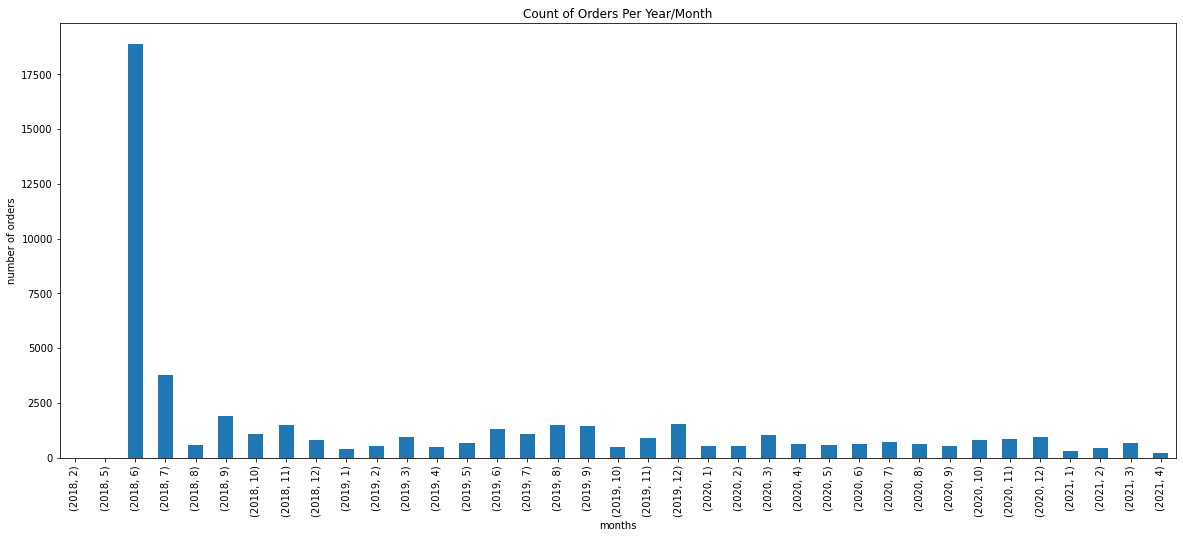

In [12]:
df.groupby(by=[df.order_datetime.dt.year, df.order_datetime.dt.month])["order_number"]\
    .count()\
    .plot(kind="bar", figsize=(20, 8), title="Count of Orders Per Year/Month")\
    .set(xlabel="months", ylabel="number of orders")

plt.show()

#### We can see that June 2018 is a large outlier that will skew our data. Hence, we will remove that from the df. 

In [13]:
df = df[df.order_datetime > datetime(2018, 7, 1)]

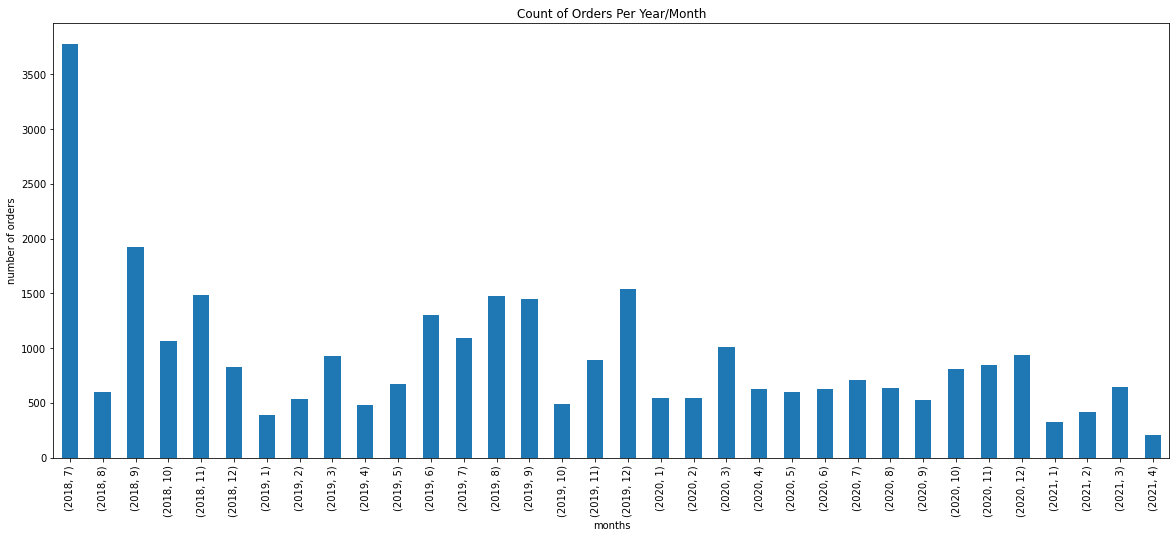

In [14]:
df.groupby(by=[df.order_datetime.dt.year, df.order_datetime.dt.month])["order_number"]\
    .count()\
    .plot(kind="bar", figsize=(20, 8), title="Count of Orders Per Year/Month")\
    .set(xlabel="months", ylabel="number of orders")

plt.show()

> There are obvious seasonality effects on the number of orders

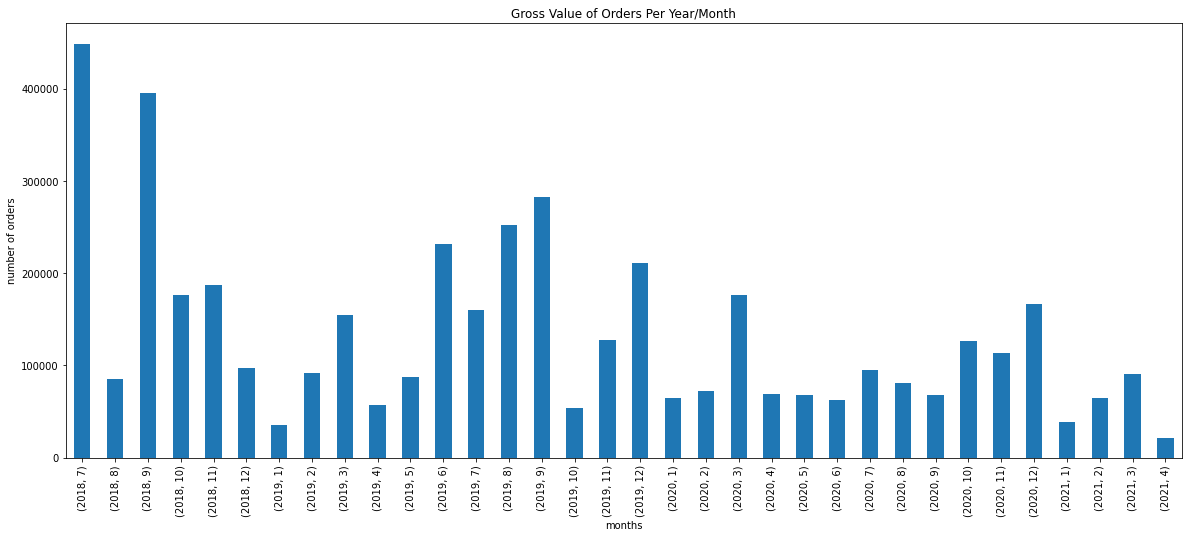

In [15]:
df.groupby(by=[df.order_datetime.dt.year, df.order_datetime.dt.month])["gross_value"]\
    .sum()\
    .plot(kind="bar", figsize=(20, 8), title="Gross Value of Orders Per Year/Month")\
    .set(xlabel="months", ylabel="number of orders")

plt.show()

> Here we can see obvious seasonality trends in the gross_value of orders

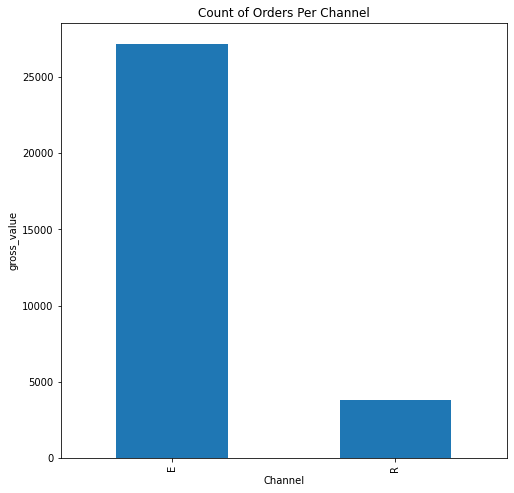

In [16]:
df.groupby("channel")["order_number"]\
    .count()\
    .plot(kind="bar", figsize=(8,8), title="Count of Orders Per Channel")\
    .set(xlabel="Channel", ylabel="gross_value")
plt.show()

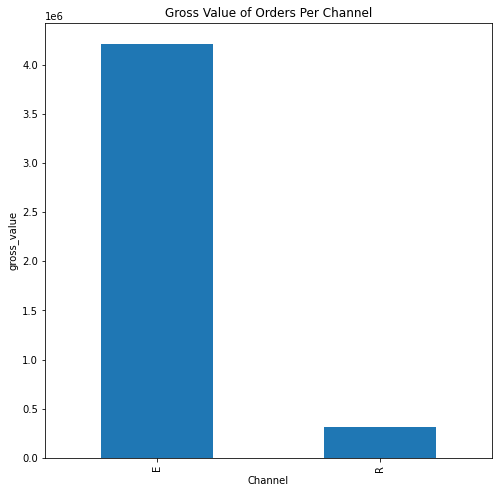

In [17]:
df.groupby("channel")["gross_value"]\
    .sum()\
    .plot(kind="bar", figsize=(8,8), title="Gross Value of Orders Per Channel")\
    .set(xlabel="Channel", ylabel="gross_value")
plt.show()

# Get Channels encoded into numeric variables

In [18]:
from sklearn.preprocessing import LabelBinarizer

channel_category = df[["channel"]]
label_binazer = LabelBinarizer()
channel_binarized = label_binazer.fit_transform(channel_category)
label_binazer_mapping = dict(zip(label_binazer.classes_, label_binazer.transform(label_binazer.classes_)))

df["channel_binarized"] = channel_binarized

df = df[["customer_id", "order_number", "order_datetime", "channel", "channel_binarized", "gross_value"]]

# Processing data

In [19]:
# Order DataFarme by date
df.sort_values("order_datetime", inplace=True)
df.reset_index(drop=True, inplace=True)

# Set the order_datetime as index
df.set_index("order_datetime", inplace=True)

In [20]:
# Getting the data by quarters

gross_value_sum = df.groupby("customer_id").resample("3M")["gross_value"].sum()
number_of_orders = df.groupby("customer_id").resample("3M")["order_number"].count()

# Since the mode built in function breaks from the multiindexing grouping
# we will define a custom one

def custom_mode(x):
    if not x.empty:
        return x.value_counts().index[0]

preferred_channel = df.groupby("customer_id").resample("3M")["channel_binarized"].agg(custom_mode)

quarterly_data_by_customer = gross_value_sum.to_frame()
quarterly_data_by_customer["preferred_channel"] = preferred_channel
quarterly_data_by_customer["order_count"] = number_of_orders

quarterly_data_by_customer.dropna(inplace=True)
quarterly_data_by_customer.reset_index(inplace=True)

> One option is to train a panel data model for each customer and treat the data as multivariate time series, however I am choosing to go with a standard model. The approach of Panel Data Model and treating the data as multivariate time series will most probably get better results, but I couldn't find a way to implement it. Hence why, I am dropping the customer_id and order_datetime and going with a more traditional approach.

In [21]:
quarterly_data = quarterly_data_by_customer.drop(columns=["customer_id", "order_datetime"])
# df1 = quarterly_data_by_customer.reset_index(level=0, drop=True)

### Split Dataset into Train and Validation sets

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,
                              test_size = 0.2,
                              random_state = 42)

for train_index, test_index in split.split(quarterly_data, quarterly_data["preferred_channel"]):
    strat_train_set = quarterly_data.loc[train_index].reset_index(drop=True)
    strat_test_set = quarterly_data.loc[test_index].reset_index(drop=True)
    
    
strat_train_set.to_csv("data/quarterly_data_train_set.csv",
                        encoding="utf8",
                        index=False)

strat_test_set.to_csv("data/quarterly_data_test_set.csv",
                        encoding="utf8",
                        index=False)

In [23]:
# Separate predictors and target
quarters = strat_train_set.drop("gross_value", axis=1)
quarters_labels = strat_train_set["gross_value"].copy()

# Selecting and Training the Model

## Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(quarters, quarters_labels)

LinearRegression()

In [25]:
some_quarters = quarters.iloc[:10]
some_quarter_labels = quarters_labels[:10]
print(f"Gross_value predictions: {lin_reg.predict(some_quarters)}")

Gross_value predictions: [123.51975029 123.51975029 123.51975029 123.51975029 123.51975029
 328.78409994 123.51975029  28.34303437 328.78409994 123.51975029]


In [26]:
print(f"Observations: {list(some_quarter_labels)}")

Observations: [235.95, 181.48, 234.3, 53.81, 220.0, 176.64999999999998, 196.65, 33.0, 505.03999999999996, 53.5]


> As we can see, Linear Regression isn't very good for our data (that of course could be because we don't have many features to work with)

In [27]:
# Getting the RMSE

from sklearn.metrics import mean_squared_error
quarter_predictions = lin_reg.predict(quarters)
lin_mse = mean_squared_error(quarters_labels, quarter_predictions)

lin_rmse = np.sqrt(lin_mse)
lin_mse

121221.40654993821

In [28]:
quarters_labels.describe()

count    16095.000000
mean       224.989822
std        553.395138
min       -279.550000
25%         66.930000
50%        140.730000
75%        239.580000
max      38078.000000
Name: gross_value, dtype: float64

> The data gross_value per quarter ranges somewhere between 66.93 and 239.58 and the typical prediction error is ~121221, which means the model isn't very accurate

## Random Forrest Regressor

In [29]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(quarters, quarters_labels)
forest_predictions = forest_reg.predict(quarters)

In [30]:
forest_mse = mean_squared_error(quarters_labels, quarter_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

348.1686467072218

> RMSE of 348 is much better.

## Using K-Fold Cross-Validation to Validate the Model

In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest_reg, quarters, quarters_labels,
                        scoring= 'neg_mean_squared_error', cv= 10)

forest_rmse_scores = np.sqrt(-scores)

def cross_val_stats(scores):
    print(f"Mean: {scores.mean()}")
    print(f"Std: {scores.std()}")

In [32]:
cross_val_stats(forest_rmse_scores)

Mean: 383.87597017186715
Std: 175.06404040185907


> The Random Forrest Regressor still overfits the data.

## Grid Search

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True
                          )
grid_search.fit(quarters, quarters_labels)

/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/igerov/Projects/gemseek/.env/lib/pyt

/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/igerov/Projects/gemseek/.env/lib/pyt

/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/igerov/Projects/gemseek/.env/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/igerov/Projects/gemseek/.env/lib/pyt

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 10}

In [35]:
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_)}")
print(f"Best params: {grid_search.best_params_}")

Best RMSE: 392.8850147897372
Best params: {'max_features': 2, 'n_estimators': 10}
